### Proyecto Final Estuardo Funes Solares Carné: 20032042

In [1]:
#Importación de Librerías

import os
import shutil
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow import keras
from sklearn.model_selection import train_test_split 

from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

#libraries for model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import datetime
import warnings
warnings.filterwarnings('ignore')

### Carga de Datos

In [2]:
data=pd.read_csv('data_titanic_proyecto.csv')

#### Análisis Exploratorio de Datos

In [3]:
data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [4]:
features=[features for features in data.columns if data[features].isnull().sum()>1]
for feature in features:
    print(feature, np.round(data[feature].isnull().mean(), 4),  ' % missing values.\n')

Age 0.1987  % missing values.

Cabin 0.771  % missing values.

Embarked 0.0022  % missing values.



### Feature Engineering

1. Viendo los valores faltantes, vemos que Cabin tiene casi el 80% de valores faltantes por lo que se elimina del análisis
2. En el caso de la Edad se imputan con valores random entre el percentil 25 y 75
3. Para la variable Embarked solamente hacen falta 2 registros, por lo que se imputa con la moda

In [5]:
data=data.drop(['PassengerId','Name','Ticket','Cabin'],1)

In [6]:
categorical_cols_data= data.select_dtypes(include=['object'])

print(f'The dataset contains {len(categorical_cols_data.columns.tolist())} categorical columns')

The dataset contains 4 categorical columns


In [7]:
categorical_cols_data.describe()

,Embarked,passenger_class,passenger_sex,passenger_survived
count,889,891,891,891
unique,3,3,2,2
top,S,Lower,M,N
freq,644,491,577,549


In [8]:
categorical_cols_missing = categorical_cols_data.columns[categorical_cols_data.isnull().any()]
categorical_cols_missing

Index(['Embarked'], dtype='object')

In [9]:
from sklearn.impute import SimpleImputer
categoricalImputer = SimpleImputer(missing_values = np.NaN,strategy = 'most_frequent')
for feature in categorical_cols_missing:
     categorical_cols_data[feature] = categoricalImputer.fit_transform(categorical_cols_data[feature].values.reshape(-1,1))
     data[feature] = categoricalImputer.fit_transform(data[feature].values.reshape(-1,1))

In [10]:
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [12]:
np.random.seed(1)
data['Age'].fillna(np.random.randint(20,38), inplace = True)
data['Age'].fillna(np.random.randint(20,38), inplace = True)
data['Fare'].fillna(np.random.randint(0,31), inplace = True)

In [13]:
data.head()

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,S,Lower,M,N
1,38.0,1,0,71.2833,C,Upper,F,Y
2,26.0,0,0,7.9250,S,Lower,F,Y
3,35.0,1,0,53.1000,S,Upper,F,Y
4,35.0,0,0,8.0500,S,Lower,M,N


In [14]:
data = data[[i for i in data.columns if i not in ('SibSp','Parch','Pclass')]]

In [15]:
data.shape

(891, 6)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 891 non-null    float64
 1   Fare                891 non-null    float64
 2   Embarked            891 non-null    object 
 3   passenger_class     891 non-null    object 
 4   passenger_sex       891 non-null    object 
 5   passenger_survived  891 non-null    object 
dtypes: float64(2), object(4)
memory usage: 41.9+ KB


### Correlación entre Variables 

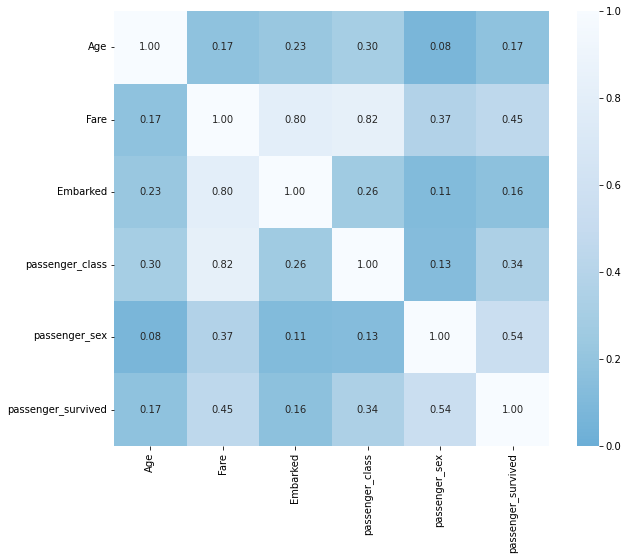

{'corr':                          Age      Fare  Embarked  passenger_class  \
 Age                 1.000000  0.173592  0.225690         0.303380   
 Fare                0.173592  1.000000  0.798351         0.822655   
 Embarked            0.225690  0.798351  1.000000         0.258312   
 passenger_class     0.303380  0.822655  0.258312         1.000000   
 passenger_sex       0.076162  0.370059  0.110742         0.129690   
 passenger_survived  0.172891  0.447880  0.164085         0.336684   
 
                     passenger_sex  passenger_survived  
 Age                      0.076162            0.172891  
 Fare                     0.370059            0.447880  
 Embarked                 0.110742            0.164085  
 passenger_class          0.129690            0.336684  
 passenger_sex            1.000000            0.540200  
 passenger_survived       0.540200            1.000000  ,
 'ax': <AxesSubplot:>}

In [17]:
cat_cols=[]
for c in data.columns:
    cat_cols.append(c)

from dython import nominal
nominal.associations(data, nominal_columns=cat_cols,figsize=(10,8),cmap="Blues_r")

#### Tranformación de Variables Categóricas a Numéricas

In [18]:
data['Embarked'].fillna(value='S',inplace=True)
data['Embarked'] = data['Embarked'].replace(['S','Q','C'],[1,2,3])

In [19]:
data['passenger_class'].replace(['Lower', 'Middle', 'Upper'],
                        [1, 2, 3], inplace=True)

In [20]:
data['passenger_sex'].replace(['M', 'F'],
                        [0, 1], inplace=True)

In [21]:
data['passenger_survived'].replace(['N', 'Y'],
                        [0, 1], inplace=True)

In [22]:
data.head()

,Age,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,7.2500,1,1,0,0
1,38.0,71.2833,3,3,1,1
2,26.0,7.9250,1,1,1,1
3,35.0,53.1000,1,3,1,1
4,35.0,8.0500,1,1,0,0


### Separación Train - Test

In [23]:
train, test = train_test_split(data, test_size = 0.20)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  712
Ejemplos usados para test:  179


### Separación Test - Validacion

In [24]:
train, validacion = train_test_split(train, test_size = 0.20)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para validacion: ", len(validacion))

Ejemplos usados para entrenar:  569
Ejemplos usados para validacion:  143


In [25]:
print(train.shape, test.shape)

(569, 6) (179, 6)


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 393 to 266
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 569 non-null    float64
 1   Fare                569 non-null    float64
 2   Embarked            569 non-null    int64  
 3   passenger_class     569 non-null    int64  
 4   passenger_sex       569 non-null    int64  
 5   passenger_survived  569 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 31.1 KB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 831 to 404
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 179 non-null    float64
 1   Fare                179 non-null    float64
 2   Embarked            179 non-null    int64  
 3   passenger_class     179 non-null    int64  
 4   passenger_sex       179 non-null    int64  
 5   passenger_survived  179 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 9.8 KB


In [28]:
validacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 116 to 879
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 143 non-null    float64
 1   Fare                143 non-null    float64
 2   Embarked            143 non-null    int64  
 3   passenger_class     143 non-null    int64  
 4   passenger_sex       143 non-null    int64  
 5   passenger_survived  143 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 7.8 KB


In [29]:
train.isnull().sum()

Age                   0
Fare                  0
Embarked              0
passenger_class       0
passenger_sex         0
passenger_survived    0
dtype: int64

In [30]:
test.isnull().sum()

Age                   0
Fare                  0
Embarked              0
passenger_class       0
passenger_sex         0
passenger_survived    0
dtype: int64

In [31]:
validacion.isnull().sum()

Age                   0
Fare                  0
Embarked              0
passenger_class       0
passenger_sex         0
passenger_survived    0
dtype: int64

### Análisis Exploratorio

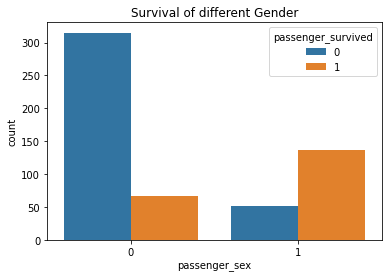

In [32]:
sns.countplot(x="passenger_sex", hue="passenger_survived", data=train)
plt.title("Survival of different Gender")
plt.show()

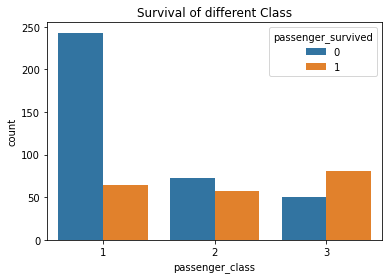

In [33]:
sns.countplot(x="passenger_class", hue="passenger_survived", data=train)
plt.title("Survival of different Class")
plt.show()

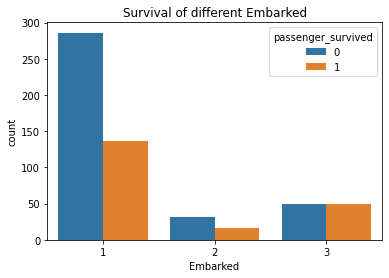

In [34]:
sns.countplot(x="Embarked", hue="passenger_survived", data=train)
plt.title("Survival of different Embarked")
plt.show()

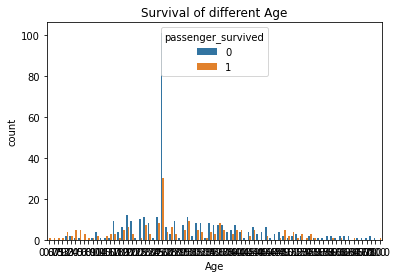

In [35]:
sns.countplot(x="Age", hue="passenger_survived", data=train)
plt.title("Survival of different Age")
plt.show()

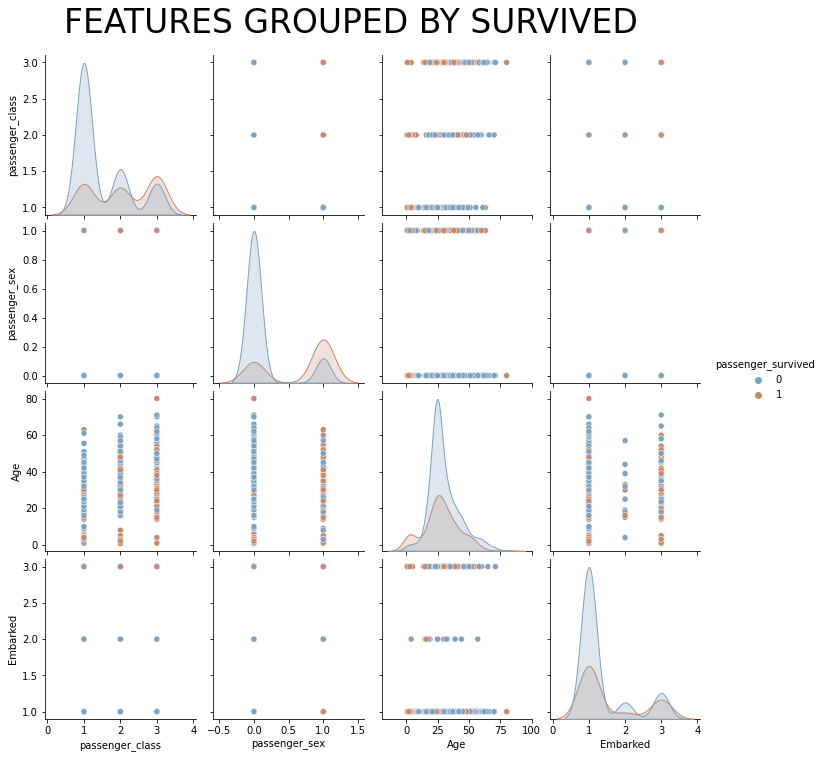

In [36]:
features = ['passenger_survived', 'passenger_class', 'passenger_sex', 'Age', 'Embarked']

pair_plt = sns.pairplot(train[features], hue="passenger_survived", palette="twilight_shifted",
                 diag_kind="kde", height=2.5)
tmp = pair_plt.fig.suptitle("FEATURES GROUPED BY SURVIVED", x=0.085, y=1.05, ha='left',
             fontweight=100, size=33)

### Modelos

In [37]:
X_train= train.drop(['passenger_survived'],1)
Y_train= train['passenger_survived']

In [38]:
X_train= train.drop(['passenger_survived'],1)
Y_train= train['passenger_survived']

In [39]:
X_train

,Age,Fare,Embarked,passenger_class,passenger_sex
393,23.0,113.2750,3,3,1
373,22.0,135.6333,3,3,0
613,25.0,7.7500,2,1,0
263,40.0,0.0000,1,3,0
83,28.0,47.1000,1,3,0
...,...,...,...,...,...
260,25.0,7.7500,2,1,0
842,30.0,31.0000,3,3,1
768,25.0,24.1500,2,1,0
178,30.0,13.0000,1,2,0


In [40]:
Y_train

393    1
373    0
613    0
263    0
83     0
      ..
260    0
842    1
768    0
178    0
266    0
Name: passenger_survived, Length: 569, dtype: int64

In [41]:
from sklearn.preprocessing import StandardScaler
X_train_scale=StandardScaler().fit_transform(X_train)
pd.DataFrame(X_train_scale).head()

,0,1,2,3,4
0,-0.483192,1.780263,2.037761,1.596066,1.423586
1,-0.560985,2.259411,2.037761,1.596066,-0.702452
2,-0.327604,-0.481186,0.739345,-0.838684,-0.702452
3,0.839301,-0.647272,-0.559072,1.596066,-0.702452
4,-0.094223,0.362102,-0.559072,1.596066,-0.702452


In [42]:
validacion_clean_x=validacion.drop(columns=['passenger_survived'])
validacion_clean_y= validacion['passenger_survived']

In [43]:
validacion_clean_x

,Age,Fare,Embarked,passenger_class,passenger_sex
116,70.5,7.7500,2,1,0
588,22.0,8.0500,1,1,0
210,24.0,7.0500,1,1,0
120,21.0,73.5000,1,2,0
888,25.0,23.4500,1,1,1
...,...,...,...,...,...
63,4.0,27.9000,1,1,0
161,40.0,15.7500,1,2,1
533,25.0,22.3583,3,1,1
883,28.0,10.5000,1,2,0


In [44]:
validacion_clean_y

116    0
588    0
210    0
120    0
888    0
      ..
63     0
161    1
533    1
883    0
879    1
Name: passenger_survived, Length: 143, dtype: int64

#### Naive Bayes

In [45]:
import csv

with open('result.csv', 'w', newline='') as f:
    thewriter = csv.writer(f)
    
    thewriter.writerow([data])

In [46]:
import csv

with open('result_dtc.csv', 'w', newline='') as f:
    thewriter = csv.writer(f)
    
    thewriter.writerow([data])

In [47]:
data = pd.DataFrame(list(data.items()))

In [48]:
data

,0,1
0,Age,0 22.0 1 38.0 2 26.0 3 35....
1,Fare,0 7.2500 1 71.2833 2 7.9250 3...
2,Embarked,0 1 1 3 2 1 3 1 4 1 ...
3,passenger_class,0 1 1 3 2 1 3 3 4 1 ...
4,passenger_sex,0 0 1 1 2 1 3 1 4 0 ...
5,passenger_survived,0 0 1 1 2 1 3 1 4 0 ...


In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
nb=GaussianNB()
scores=cross_val_score(nb, X_train, Y_train, cv=5)
print(scores)
print(scores.mean())

y_pred_nb=GaussianNB().fit(X_train, Y_train).predict(validacion_clean_y)
data={'PassengerId': result['PassengerId'],'passenger_survived':y_pred_nb}
result_nb=pd.DataFrame(data=data)
result_nb.to_csv('C:/Users/EFunes/Documents/PERSONAL/U/Galileo/II Ciclo/Statistical Learning I/Proyecto-20220419T014445Z-001/Proyecto/result.csv', index=False)
result_nb=pd.read_csv('C:/Users/EFunes/Documents/PERSONAL/U/Galileo/II Ciclo/Statistical Learning I/Proyecto-20220419T014445Z-001/Proyecto/result.csv')




[0.78070175 0.81578947 0.85087719 0.78947368 0.74336283]
0.7960409874243132


ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1
 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1
 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

#### Regresión Logística 

In [50]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression().fit(X_train_scale, Y_train)
y_pred=LR.predict(validacion_clean_x)
from sklearn.metrics import classification_report


from sklearn.model_selection import cross_val_score
scores=cross_val_score(LogisticRegression(),X_train_scale,Y_train,cv=5)
print(scores)
print(scores.mean())

[0.80701754 0.83333333 0.83333333 0.75438596 0.79646018]
0.8049060704859494


train accuracy: 0.8084358523725835 
 validacion accuracy: 0.7972027972027972


classification report for logistic regression
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.79      0.72      0.75        61

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



confusion matrix for logistic regression


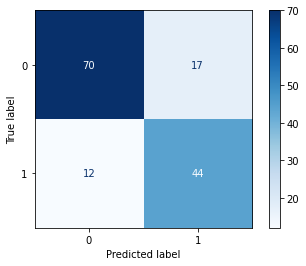

In [51]:
#logistic regression
lr = LogisticRegression(max_iter=2000,penalty='l2')
model1=lr.fit(X_train, Y_train)
print("train accuracy:",model1.score(X_train, Y_train),"\n","validacion accuracy:",model1.score(validacion_clean_x,validacion_clean_y))
lrpred = lr.predict(validacion_clean_x)
print("\n")
print("classification report for logistic regression")
print(classification_report(lrpred,validacion_clean_y))
print("\n")
print("confusion matrix for logistic regression")
displr = plot_confusion_matrix(lr, validacion_clean_x, validacion_clean_y, cmap=plt.cm.Blues , values_format='d')

#### Arbol de decisión

train accuracy: 0.9806678383128296 
 validacion accuracy: 0.8321678321678322


classification report for decision tree classifier
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        85
           1       0.80      0.78      0.79        58

    accuracy                           0.83       143
   macro avg       0.83      0.82      0.82       143
weighted avg       0.83      0.83      0.83       143



confusion matrix for decision tree classifier


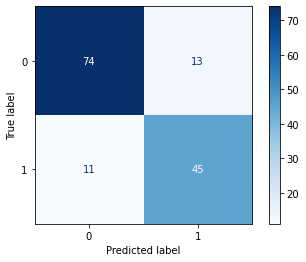

In [52]:
#decision tree classifier
dt=DecisionTreeClassifier()
model3=dt.fit(X_train, Y_train)
print("train accuracy:",model3.score(X_train, Y_train),"\n","validacion accuracy:",model3.score(validacion_clean_x,validacion_clean_y))

dtpred = dt.predict(validacion_clean_x)
print("\n")
print("classification report for decision tree classifier")
print(classification_report(dtpred,validacion_clean_y))
print("\n")
print("confusion matrix for decision tree classifier")
displr = plot_confusion_matrix(dt, validacion_clean_x, validacion_clean_y ,cmap=plt.cm.Blues , values_format='d')

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dtc=DecisionTreeClassifier()
scores=cross_val_score(dtc, X_train, Y_train, cv=5)
print(scores)
print(scores.mean())

y_pred_dtc=DecisionTreeClassifier().fit(X_train, Y_train).predict(validacion_clean_x)
data={'PassengerId': result['PassengerId'],'passenger_survived':y_pred_dtc}
result_dtc=pd.DataFrame(data)
result_dtc.to_csv('C:/Users/EFunes/Documents/PERSONAL/U/Galileo/II Ciclo/Statistical Learning I/Proyecto-20220419T014445Z-001/Proyecto/result_dtc.csv', index=True)
result_dtc=pd.read_csv('C:/Users/EFunes/Documents/PERSONAL/U/Galileo/II Ciclo/Statistical Learning I/Proyecto-20220419T014445Z-001/Proyecto/result_dtc.csv')

[0.78947368 0.83333333 0.79824561 0.79824561 0.78761062]
0.8013817730166123


NameError: name 'result' is not defined

#### SVM con sklearn

In [54]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc=SVC(kernel='linear', C=1)
scores=cross_val_score(svc, X_train_scale, Y_train, cv=5)
print(scores)
print(scores.mean())

[0.79824561 0.8245614  0.8245614  0.76315789 0.76106195]
0.7943176525384257


In [55]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

[Ellipsis]

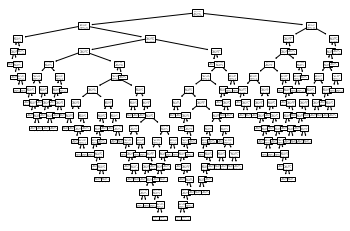

In [56]:
tree.plot_tree(clf)
[...]

### Investigación de K Fold

##### K-fold cross-validation es una técnica superior para validar el rendimiento o performance de nuestro modelo. Evalúa el modelo utilizando diferentes pedazos (chunks) del set de datos como por ejemplo los datos de validación.

##### Se divide la data en K folds. K representa el número de pliegues (folds) en el cual se quiere dividir la data. Si utilizamos 5 folds, el set de datos será dividido en 5 secciones. En cada iteración, una parte se convierte en el set de validaciones.

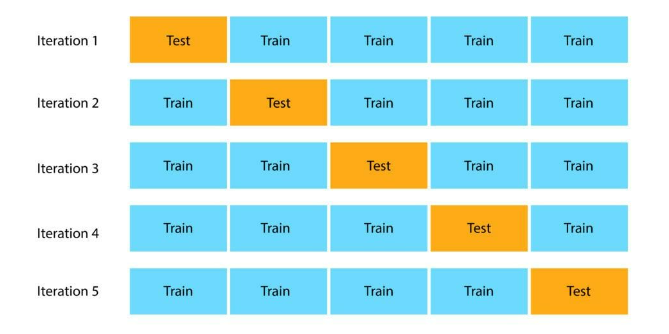

##### Este método garantiza que el score de nuestro modelo no depende en la manera que seleccionamos el set de entrenamiento y el set de pruebas. Los pasos son:
1. De manera aleatoria dividir el set completo de datos en el K Folds definidos (subsets de 3, 5, etc.)
2. Por cada uno de los folds en el dataset, se construye el modelo con K-1 folds del dataset. Después hay que probar el modelo para validar la efectividad del kth Fold
3. Repetir esto hasta que cada K Folds ha sido utilizado para el set de pruebas.
4. El promedio del registro K es llamado "cross-validation accuracy" y será utilizado como la métrica de rendimiento del modelo.

#### Conclusiones de KFolds

##### Es ideal cuando se tiene un set de data pequeño, pero cuando es set de data es inmenso no hace falta utilizar KFolds, ya que se tienen suficientes registros para validar el modelo de Machine Learning. Toma demasiado tiempo utilizar KFolds cross validation en un set de data muy extenso.

##### Finalmente, si utilizamos muchos K Folds para validar el modelo, esto implica un alto consumo computacional. Mientras más alto sea el valor de K, mayor será el tiempo de entrenamiento del modelo. Si utilizamos K=5, el modelo de entrenamiento corre 5 veces utilizando 5 diferentes folds, si es K=10 10 diferentes folds, y así sucesivamente.

https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f

### Aplicación de K Folds en Data Train Titanic

In [57]:
X= train.drop(columns=['passenger_survived'])
y= train['passenger_survived']

In [58]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

# cv=10 for 5 folds

scores_accuracy = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=5, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.803
LogisticRegression average log_loss is 0.431
LogisticRegression average auc is 0.853


### Aplicación de K Folds en Data Test Titanic

In [59]:
Xtest= test.drop(columns=['passenger_survived'])
ytest= test['passenger_survived']

In [60]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

# cv=10 for 5 folds

scores_accuracy = cross_val_score(logreg, Xtest, ytest, cv=5, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, Xtest, ytest, cv=5, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, Xtest, ytest, cv=5, scoring='roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.743
LogisticRegression average log_loss is 0.526
LogisticRegression average auc is 0.812


### Predicción

#### Naives Bayes

In [61]:
x_test= train.drop(['passenger_survived'],1)
y_test= train['passenger_survived']

In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
nb=GaussianNB()
scores=cross_val_score(nb, x_test, y_test, cv=5)
print(scores)
print(scores.mean())

y_pred_nb=GaussianNB().fit(x_test, y_test).predict(test)
data={'PassengerId': data_titanic_proyecto['PassengerId'],'passenger_survived':y_pred_nb}
result_nb=pd.DataFrame(data)
result_nb.to_csv('C:/Users/EFunes/Documents/PERSONAL/U/Galileo/II Ciclo/Statistical Learning I/Proyecto-20220419T014445Z-001/Proyecto/result_dtc.csv', index=False)
result_nb=pd.read_csv('C:/Users/EFunes/Documents/PERSONAL/U/Galileo/II Ciclo/Statistical Learning I/Proyecto-20220419T014445Z-001/Proyecto/result_dtc.csv')

[0.78070175 0.81578947 0.85087719 0.78947368 0.74336283]
0.7960409874243132


ValueError: X has 6 features, but GaussianNB is expecting 5 features as input.

#### Regresión Logística

train accuracy: 0.8084358523725835 
 test accuracy: 0.8084358523725835


classification report for logistic regression
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       375
           1       0.71      0.74      0.73       194

    accuracy                           0.81       569
   macro avg       0.79      0.79      0.79       569
weighted avg       0.81      0.81      0.81       569



confusion matrix for logistic regression


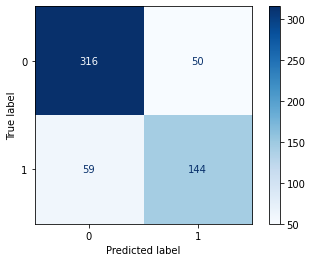

In [63]:
#logistic regression
lr = LogisticRegression(max_iter=2000,penalty='l2')
model1=lr.fit(x_test, y_test)
print("train accuracy:",model1.score(x_test, y_test),"\n","test accuracy:",model1.score(x_test,y_test))
lrpred = lr.predict(x_test)
print("\n")
print("classification report for logistic regression")
print(classification_report(lrpred,y_test))
print("\n")
print("confusion matrix for logistic regression")
displr = plot_confusion_matrix(lr, x_test, y_test, cmap=plt.cm.Blues , values_format='d')

#### Árbol de Decisión

train accuracy: 0.9806678383128296 
 test accuracy: 0.9806678383128296


classification report for decision tree classifier
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       375
           1       0.95      0.99      0.97       194

    accuracy                           0.98       569
   macro avg       0.97      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



confusion matrix for decision tree classifier


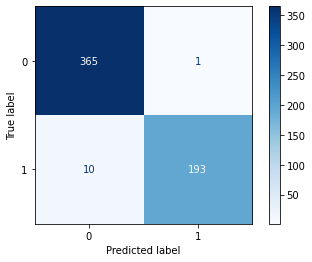

In [64]:
#decision tree classifier
dt=DecisionTreeClassifier()
model3=dt.fit(x_test, y_test)
print("train accuracy:",model3.score(x_test, y_test),"\n","test accuracy:",model3.score(x_test,y_test))

dtpred = dt.predict(x_test)
print("\n")
print("classification report for decision tree classifier")
print(classification_report(dtpred,y_test))
print("\n")
print("confusion matrix for decision tree classifier")
displr = plot_confusion_matrix(dt, x_test, y_test ,cmap=plt.cm.Blues , values_format='d')

In [65]:
import tensorflow as tf
import datetime
import sklearn
from tensorflow import keras

In [66]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [67]:
def gradient_descent(x, y, epochs, lr, print_rate=100):
    #tf.reset_default_graph()
    tf.compat.v1.reset_default_graph()
    
    with tf.name_scope("input"):
        x = tf.concat([x, tf.ones_like(x)], axis = 1)
    with tf.name_scope("params"):
        params = tf.Variable(name="params", initial_value = tf.zeros((2, 1), tf.float64))
    with tf.name_scope("Modelo"):
        y_hat = tf.matmul(x, params)
    with tf.name_scope("error"):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
    with tf.name_scope("gradient"):
        gradients = tf.gradients(error, params)
    with tf.name_scope("update_model"):
        fit = tf.scalar_mul(-lr, gradients[0])
        update_model = tf.compat.v1.assign(params, tf.add(params, fit))


    with tf.Session() as session:
        summary = tf.summary.scalar(name = "error_epochs", tensor = error)
        writer = tf.summary.FileWriter("./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs), session.graph)
        session.run(tf.global_variables_initializer())
        for epoch in range(0, epochs):
            if ((epoch + 1) % print_rate) == 0:
                print("error: " + str(session.run(error)))
      
            writer.add_summary(session.run(summary), epoch)
            session.run(update_model)

        params = session.run(params)

        writer.close()
    session.close()

    return params

In [68]:
# Se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
n = len(train)
a = np.array(train["passenger_sex"]).reshape(n,1)
b = np.array(train["passenger_class"]).reshape(n,1)

ab = np.multiply(a,b)
a2 = np.multiply(a,a)
b2 = np.multiply(b,b)

# el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columna
ones = np.ones(shape=[n,1])
#x = np.ndarray([[ones],[a],[b],[a2],[b2],[ab]])
x = np.concatenate ([ones,a,b,a2,b2,ab], axis=1)
#y = np.array(data["passenger_survived"]).reshape(n,1)
y_test= train['passenger_survived']


#x = tf.concat ([ones,a,b,a2,b2,ab], axis=1)

In [69]:
data

,0,1
0,Age,0 22.0 1 38.0 2 26.0 3 35....
1,Fare,0 7.2500 1 71.2833 2 7.9250 3...
2,Embarked,0 1 1 3 2 1 3 1 4 1 ...
3,passenger_class,0 1 1 3 2 1 3 3 4 1 ...
4,passenger_sex,0 0 1 1 2 1 3 1 4 0 ...
5,passenger_survived,0 0 1 1 2 1 3 1 4 0 ...


In [70]:
#tf.reset_default_graph()


tf.compat.v1.reset_default_graph()
g = tf.Graph()
with g.as_default():
    X = tf.placeholder("float", [None,6], name="X")
    Y = tf.placeholder("float", [None,1], name="Y")
    learning_rate = tf.placeholder("float")
    W = tf.Variable(tf.zeros((6,1)), name = "W", dtype="float")
    b = tf.Variable(tf.zeros(1), name = "b", dtype="float")
    with tf.name_scope("Modelo"):
        y_pred = tf.add(tf.matmul(X,W), b)
    with tf.name_scope("Costo"):
        cost = tf.reduce_sum(tf.pow(y_pred-Y, 2)) / (2*n)
        cost_summary = tf.summary.scalar("Costo", cost)
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

In [71]:
def training(lr):
    tf.reset_default_graph()
    
    with tf.Session(graph=g) as sess:
        
        writer = tf.summary.FileWriter("./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs), session.graph)
        sess.run(init)
        for epoch in range(51):
                                       
            sess.run(optimizer, feed_dict = {X : x, Y : y, learning_rate:lr})
                                       
            if (epoch+1) % 10 == 0:
                c,co,we,inte=sess.run([cost_summary,cost,W,b], feed_dict = {X : x, Y : y, learning_rate:lr})
            
                writer.add_summary(c, epoch+1)
                print("Epoch", (epoch + 1), ": cost= ", co, "W = ", we, "b = ", inte)
                                       
        writer.close()

#### Cargar otras librerias

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, BatchNormalization,Concatenate, concatenate
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import *
from sklearn.model_selection import StratifiedKFold

In [73]:
metrics = ['accuracy', 
           Precision(),
           Recall()]

In [75]:
def create_model():
    model = Sequential()
    model.add(Input(shape=X_train.shape[1], name='Input_'))
    model.add(Dense(8, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.summary()
    optimize = Adam(lr = 0.0001)
    model.compile(optimizer = optimize, 
                       loss = 'binary_crossentropy', 
                       metrics = metrics)
    return model

In [76]:
estimator = KerasClassifier(build_fn = create_model, epochs = 100, batch_size = 32, verbose = 1)
kfold = StratifiedKFold(n_splits = 3)
results = cross_val_score(estimator, X_train, Y_train, cv = kfold)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 48        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable pa

In [77]:
train_history = estimator.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 48        
                                                                 
 dense_13 (Dense)            (None, 16)                144       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable 

In [78]:
import csv

with open('result.csv', 'w', newline='') as f:
    thewriter = csv.writer(f)
    
    thewriter.writerow([data])

In [79]:
print(train_history.history.keys())

dict_keys(['loss', 'acc', 'precision', 'recall'])


NameError: name 'ticker' is not defined

findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


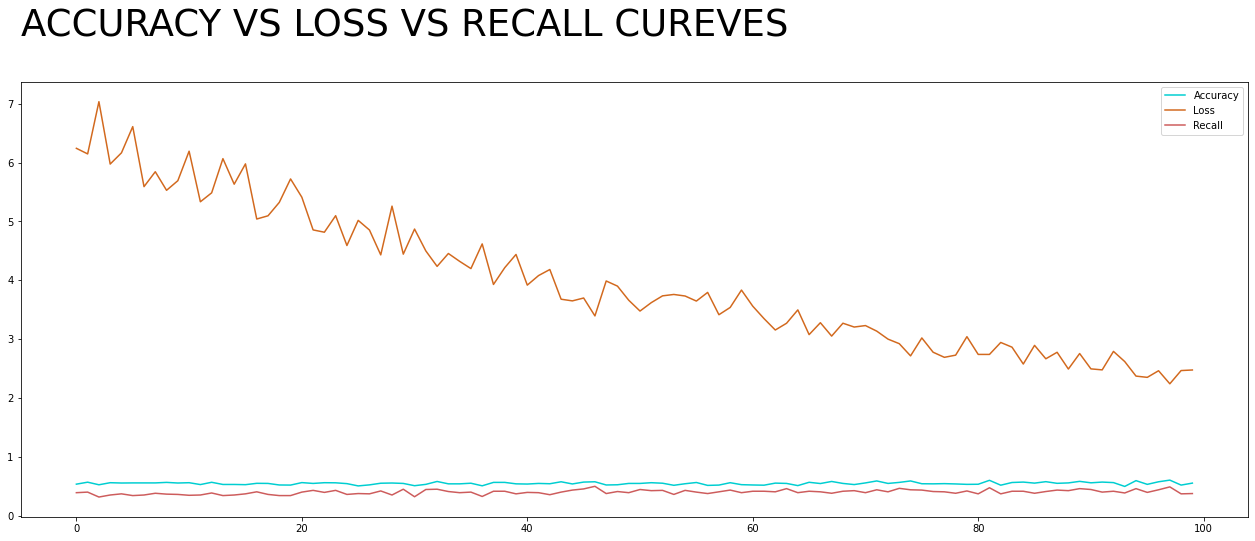

In [80]:

fig = plt.figure(figsize=(22,8))
hist = sns.lineplot(data=train_history.history['acc'], color="darkturquoise", label='Accuracy')
hist = sns.lineplot(data=train_history.history['loss'], color="chocolate", label='Loss')
hist = sns.lineplot(data=train_history.history['recall'], color="indianred", label='Recall')

title = fig.suptitle("ACCURACY VS LOSS VS RECALL CUREVES", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=37)

hist.xaxis.set_major_locator(ticker.MultipleLocator(20))
hist.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.legend()
plt.show()

### Conclusiones y Aprendizaje

1. Existen variables en el DATASET irrelevantes para el análisis, ya que no representan información  como son:
    -PassengerId
    -Name

2. Existen otras variables con valores faltantes:
    -Age 0.1987  % missing values. Se decide imputar números aleatorios que se encuentren entre el 1er y 3er percentil.
    -Cabin 0.771  % missing values. Se decide eliminar del análisis porque es casi el 80% de los datos, por lo que utilizar esta variable para un análisis predictivo no sería lo más correcto. Además que existen otras variables que pueden sustituir a esta, por ejemplo: Passenger_Class o Fare.
    -Embarked 0.0022  % missing values. Son únicamente 2 valores y se imputan con la moda.
    
3. Existen variables que pueden considerarse como duplicadas para el análisis de predicción, como lo son Fare, Cabin y Passenger_Class, ya que estas 3 hacen referencia a la localidad o ubicación en las que se encontraban las personas, y se pueden clasificar en Clase Baja (Passenger_Class = "Lower", Passenger_Class = "Middle", Passenger_Class = "Upper").

4. Después de hacer Features Engineering vemos que las variables que tiene correlación con la variable a predecir son:
    -Age
    -Fare-
    -Embarked
    -Passenger_Sex
    -Passenger_Class
    
5. Las Variables que tienen mejor correlación con la variable Passenger_Survived son:
    -Passenger_Class (0.34)
    -Passenger_Sex (0.54)
    
6. El Modelo de Regresión Logística (0.80) y Árbol de Decisión (0.82) son los modelos que mejor resultados dan.

7. El Modelo de K Folds es una técnica para validar el rendimiento o performance de nuestro modelo, que divide el set de datos y en cada iteración, una parte se convierte en el set de validaciones. 

8. El proceso de Feature Engineering es el proceso que más tiempo consume y en lo personal el más importante, porque de no hacerse los resultados no serán los esperandos. Como dice el dicho "Garbage In, Garbage Out" aplica para todo, incluido Machine Learning.

9. Existen muchas variedades de modelos de predicción, y cada uno es muy particular, por lo que es necesario especializarse en cada uno y poder dominarlo para hacer mejores predicciones.

10. 




## Ensayo SVM

### Introducción

##### Máquinas de Vector Soporte (Vector Support Machines, SVMs) es un algoritmo de clasificación y regresión. Aunque inicialmente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión. SVMs ha resultado ser uno de los mejores clasificadores para un amplio abanico de situaciones, por lo que se considera uno de los referentes dentro del ámbito de aprendizaje estadístico y machine learning.

##### Las Máquinas de Vector Soporte se fundamentan en el Maximal Margin Classifier, que a su vez, se basa en el concepto de hiperplano. 

##### La librería Scikit Learn contiene implementaciones en Python de los principales algoritmos de SVM.

### Hiperplano y Maximal Margin Classifier

##### En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones  p−1 . El término afín significa que el subespacio no tiene por qué pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones  p>3  no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con  p−1  dimensiones se mantiene.

##### La definición matemática de un hiperplano es bastante simple. En el caso de dos dimensiones, el hiperplano se describe acorde a la ecuación de una recta:

$$ \beta_0 + \beta_1 * X_1 + \beta_2 * X_2 = 0 $$ 

##### Dados los parámetros  β0 ,  β1  y  β2 , todos los pares de valores  x=(x1,x2)  para los que se cumple la igualdad son puntos del hiperplano. Esta ecuación puede generalizarse para p-dimensiones:

$$ \beta_0 + \beta_1 * X_1 + \beta_2 * X_2 + ... + \beta_p * X_p = 0 $$

##### y de igual manera, todos los puntos definidos por el vector  (x=x1,x2,...,xp)  que cumplen la ecuación pertenecen al hiperplano. Cuando  x  no satisface la ecuación:

$$ \beta_0 + \beta_1 * X_1 + \beta_2 * X_2 + ... + \beta_p * X_p < 0 $$

##### o bien

$$ \beta_0 + \beta_1 * X_1 + \beta_2 * X_2 + ... + \beta_p * X_p > 0 $$

##### el punto  x  cae a un lado o al otro del hiperplano. Así pues, se puede entender que un hiperplano divide un espacio p-dimensional en dos mitades. Para saber en qué lado del hiperplano se encuentra un determinado punto  x , solo hay que calcular el signo de la ecuación.

##### La siguiente imagen muestra el hiperplano de un espacio bidimensional. La ecuación que describe el hiperplano (una recta) es  1+2x1+3x2=0 . La región azul representa el espacio en el que se encuentran todos los puntos para los que  1+2x1+3x2>0  y la región roja el de los puntos para los que  1+2x1+3x2<0 .

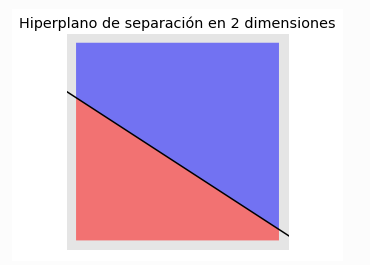

### Clasificación binaria empleando un hiperplano

##### Cuando se dispone de  n  observaciones, cada una con  p  predictores y cuya variable respuesta tiene dos niveles (de aquí en adelante identificados como  +1  y  −1 ), se pueden emplear hiperplanos para construir un clasificador que permita predecir a qué grupo pertenece una observación en función de sus predictores.

##### Para facilitar la comprensión, las siguientes explicaciones se basan en un espacio de dos dimensiones, donde un hiperplano es una recta. Sin embargo, los mismos conceptos son aplicables a dimensiones superiores.


#### CASOS PERFECTAMENTE SEPARABLES LINEALMENTE

##### Si la distribución de las observaciones es tal que se pueden separar linealmente de forma perfecta en las dos clases ( +1  y  −1 ), entonces, un hiperplano de separación cumple que:

$$ \beta_0 + \beta_1 * X_1 + \beta_2 * X_2 + ... + \beta_p * X_p > 0, si Y_i = 1 $$

$$ \beta_0 + \beta_1 * X_1 + \beta_2 * X_2 + ... + \beta_p * X_p < 0, si Y_i = -1 $$

##### Bajo este escenario, el clasificador más sencillo consiste en asignar cada observación a una clase dependiendo del lado del hiperplano en el que se encuentre. Es decir, la observación  x*  se clasifica acorde al signo de la función  f(x*)=β0+β1x∗1+β2x∗2+...+βpx∗p . Si  x*  es positiva, la observación se asigna a la clase  +1 , si es negativa, a la clase  −1 . Además, la magnitud de  x*  permite saber cómo de lejos está la observación del hiperplano y con ello la confianza de la clasificación (no confundir esto con un valor de probabilidad).

##### La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

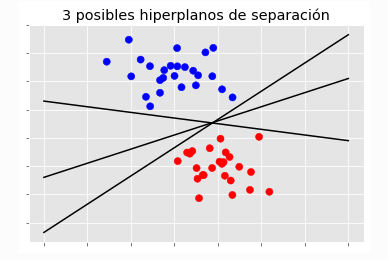

##### La solución a este problema consiste en seleccionar como clasificador óptimo el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. A este se le conoce como como maximal margin hyperplane o hiperplano óptimo de separación. Para identificarlo, se tiene que calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cuán alejado está el hiperplano de las observaciones de entrenamiento. Así pues, el maximal margin hyperplane se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización dual.

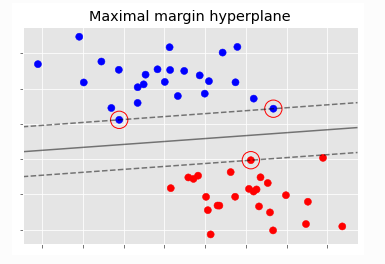

##### La imagen anterior muestra el maximal margin hyperplane, formado por el hiperplano (línea negra continua y su margen (las dos líneas discontinuas). Las tres observaciones equidistantes respecto al maximal margin hyperplane que se encuentran a lo largo de las líneas discontinuas se les conoce como vectores soporte, ya que son vectores en un espacio p-dimensional y soportan (definen) el maximal margin hyperplane. Cualquier modificación en estas observaciones (vectores soporte) conlleva cambios en el maximal margin hyperplane. Sin embargo, modificaciones en observaciones que no son vector soporte no tienen impacto alguno en el hiperplano.

### Support Vector Classifier o Soft Margin SVM

##### El Maximal Margin Classifier descrito en la sección anterior tiene poca aplicación práctica, ya que rara vez se encuentran casos en los que las clases sean perfecta y linealmente separables. De hecho, incluso cumpliéndose estas condiciones ideales, en las que exista un hiperplano capaz de separar perfectamente las observaciones en dos clases, esta aproximación sigue presentando dos inconvenientes:

    -Dado que el hiperplano tiene que separar perfectamente las observaciones, es muy sensible a variaciones en los datos. Incluir una nueva observación puede suponer cambios muy grandes en el hiperplano de separación (poca robustez).

    -Que el maximal margin hyperplane se ajuste perfectamente a las observaciones de entrenamiento para separarlas todas correctamente suele conllevar problemas de overfitting.

##### Por estas razones, es preferible crear un clasificador basado en un hiperplano que, aunque no separe perfectamente las dos clases, sea más robusto y tenga mayor capacidad predictiva al aplicarlo a nuevas observaciones (menos problemas de overfitting). Esto es exactamente lo que consiguen los clasificadores de vector soporte, también conocidos como soft margin classifiers o Support Vector Classifiers. Para lograrlo, en lugar de buscar el margen de clasificación más ancho posible que consigue que las observaciones estén en el lado correcto del margen; se permite que ciertas observaciones estén en el lado incorrecto del margen o incluso del hiperplano.

##### La siguiente imagen muestra un clasificador de vector soporte ajustado a un pequeño set de observaciones. La línea continua representa el hiperplano y las líneas discontinuas el margen a cada lado. Las observaciones 2, 3, 4, 5, 6, 7, 9 y 10 se encuentran en el lado correcto del margen (también del hiperplano) por lo que están bien clasificadas. Las observaciones 1 y 8, a pesar de que se encuentran dentro del margen, están en el lado correcto del hiperplano, por lo que también están bien clasificadas. Las observaciones 11 y 12, se encuentran en el lado erróneo del hiperplano, su clasificación es incorrecta. Todas aquellas observaciones que, estando dentro o fuera del margen, se encuentren en el lado incorrecto del hiperplano, se corresponden con observaciones de entrenamiento mal clasificadas.

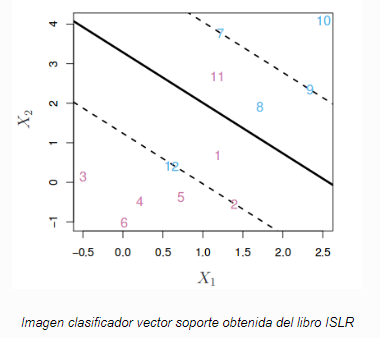

##### La identificación del hiperplano que clasifique correctamente la mayoría de las observaciones a excepción de unas pocas, es un problema de optimización convexa. Si bien la demostración matemática queda fuera del objetivo de esta introducción, es importante mencionar que el proceso incluye un hiperparámetro llamado  C .  C  controla el número y severidad de las violaciones del margen (y del hiperplano) que se toleran en el proceso de ajuste. Si  C=∞ , no se permite ninguna violación del margen y por lo tanto, el resultado es equivalente al Maximal Margin Classifier (teniendo en cuenta que esta solución solo es posible si las clases son perfectamente separables). Cuando más se aproxima  C  a cero, menos se penalizan los errores y más observaciones pueden estar en el lado incorrecto del margen o incluso del hiperplano.  C  es a fin de cuentas el hiperparámetro encargado de controlar el balance entre bias y varianza del modelo. En la práctica, su valor óptimo se identifica mediante validación cruzada.

##### El proceso de optimización tiene la peculiaridad de que solo las observaciones que se encuentran justo en el margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte y son las que definen el clasificador obtenido. Esta es la razón por la que el parámetro  C  controla el balance entre bias y varianza. Cuando el valor de  C  es pequeño, el margen es más ancho, y más observaciones violan el margen, convirtiéndose en vectores soporte. El hiperplano está, por lo tanto, sustentado por más observaciones, lo que aumenta el bias pero reduce la varianza. Cuando mayor es el valor de  C , menor el margen, menos observaciones son vectores soporte y el clasificador resultante tiene menor bias pero mayor varianza.

##### Otra propiedad importante que deriva de que el hiperplano dependa únicamente de una pequeña proporción de observaciones (vectores soporte), es su robustez frente a observaciones muy alejadas del hiperplano. Esto hace al método de clasificación vector soporte distinto a otros métodos tales como Linear Discrimiant Analysis (LDA), donde la regla de clasificación depende de la media de todas las observaciones.

#### Support Vector Machine

##### El Support Vector Classifier descrito en los apartados anteriores consigue buenos resultados cuando el límite de separación entre clases es aproximadamente lineal. Si no lo es, su capacidad decae drásticamente. Una estrategia para enfrentarse a escenarios en los que la separación de los grupos es de tipo no lineal consiste en expandir las dimensiones del espacio original.

##### El hecho de que los grupos no sean linealmente separables en el espacio original no significa que no lo sean en un espacio de mayores dimensiones. Las imágenes siguientes muestran dos grupos cuya separación en dos dimensiones no es lineal, pero sí lo es al añadir una tercera dimensión.

##### El método de Máquinas Vector Soporte (SVM) se puede considerar como una extensión del Support Vector Classifier obtenida al aumentar la dimensión de los datos. Los límites de separación lineales generados en el espacio aumentado se convierten en límites de separación no lineales al proyectarlos en el espacio original.

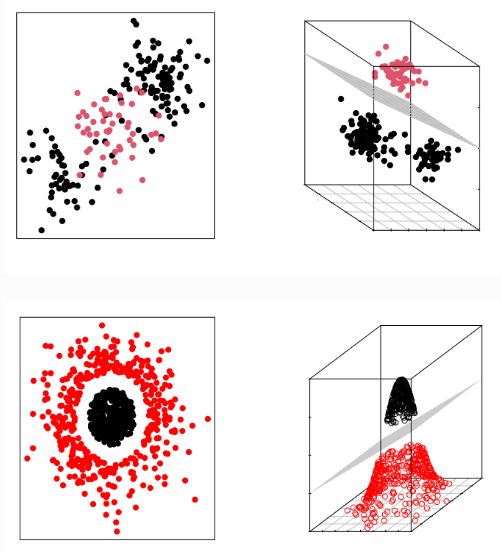

#### Aumento de la dimensión: kernels

##### Una vez definido que las Máquinas de Vector Soporte siguen la misma estratégica que el Support Vector Classifier, pero aumentando la dimensión de los datos antes de aplicar el algoritmo, la pregunta inmediata es ¿Cómo se aumenta la dimensión y qué dimensión es la correcta?

##### La dimensión de un conjunto de datos puede transformarse combinando o modificando cualquiera de sus dimensiones. Por ejemplo, se puede transformar un espacio de dos dimensiones en uno de tres aplicando la siguiente función:

$$ f(X_1,X_2) = (X^2_1, \sqrt{2X_1*X_2,} X2_2) $$

##### Esta es solo una de las infinitas transformaciones posibles, ¿Cómo saber cuál es la adecuada? Es aquí donde el concepto de kernel entra en juego. Un kernel (K) es una función que devuelve el resultado del producto escalar entre dos vectores realizado en un nuevo espacio dimensional distinto al espacio original en el que se encuentran los vectores. Aunque no se ha entrado en detalle en las fórmulas matemáticas empleadas para resolver el problema de optimización, esta contiene un producto escalar. Si se sustituye este producto escalar por un kernel, se obtienen directamente los vectores soporte (y el hiperplano) en la dimensión correspondiente al kernel. Ha esto se le suele conocer como kernel trickporque, con solo una ligera modificación del problema original, se puede obtener el resultado para cualquier dimensión. Existen multitud de kernels distintos, algunos de los más utilizados son:

##### **Kernel Lineal**

$$ K (X, X^,) = X * X ^, $$

##### Si se emplea un Kernel lineal, el clasificador Support Vector Machine obtenido es equivalente al Support Vector Classifier.

##### **Kernel Polinómico**

$$ K (X, X^,) = (X * X ^, + c)^d $$

##### **Gaussian Kernel (RBK)**

$$ K (X, X^,) = exp (-\gamma \mid \mid X - X ^, \mid \mid^2) $$

##### El valor de  γ  controla el comportamiento del kernel, cuando es muy pequeño, el modelo final es equivalente al obtenido con un kernel lineal, a medida que aumenta su valor, también lo hace la flexibilidad del modelo.


##### Los kernels descritos son solo unos pocos de los muchos que existen. Cada uno tiene una serie de hiperparámetros cuyo valor óptimo puede encontrarse mediante validación cruzada. No puede decirse que haya un kernel que supere al resto, depende en gran medida de la naturaleza del problema que se esté tratando. Ahora bien, tal como indican los autores de A Practical Guide to Support Vector Classification, es muy recomendable probar el kernel RBF. Este kernel tiene dos ventajas: que solo tiene dos hiperparámetros que optimizar ( γ  y la penalización  C  común a todos los SVM) y que su flexibilidad puede ir desde un clasificador lineal a uno muy complejo.


- https://www.youtube.com/watch?v=vMmG_7JcfIc
- https://www.youtube.com/watch?v=pdR9_eylib8&t=6134s
- https://www.youtube.com/watch?v=VWwb3IAB6Rc
- https://www.youtube.com/watch?v=envRLLZmio8
- https://github.com/yanshengjia/ml-road/blob/master/resources/Hands%20On%20Machine%20Learning%20with%20Scikit%20Learn%20and%20TensorFlow.pdf